In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import random
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import numpy as np
import os

In [21]:
ruta_train = os.path.join("..","..","..", "data", "P1","train.parquet")
train = pd.read_parquet(ruta_train) 
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_test = os.path.join("..","..","..", "data", "P1","test.parquet")
test = pd.read_parquet(ruta_test) 
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

In [22]:
X_train = train.drop(columns=["WINNER"])
y_train = train["WINNER"]

X_test = test.drop(columns=["WINNER"])
y_test = test["WINNER"]

### BASELINE PARA P1

Gana el que haya dado más golpes

In [23]:
y_pred = X_test["SIG_STR_DIFF"] < 0
accuracy_score(y_test,y_pred)

0.7085798816568047

In [24]:
# Crear el modelo con los mejores hiperparámetros encontrados
mejor_arbol = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=13,
    random_state=42
)

# Entrenar el modelo
mejor_arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=13,
                       random_state=42)

In [25]:
from xgboost import XGBClassifier

# Crear el modelo con los mejores hiperparámetros encontrados
mejor_xgboost = XGBClassifier(
    alpha=0,
    colsample_bytree=0.7,
    gamma=0,
    reg_lambda=1.0,
    learning_rate=0.3,
    max_depth=3,
    min_child_weight=2,
    n_estimators=200,
    scale_pos_weight=1,
    subsample=0.8,
    random_state=42
)

# Entrenar el modelo
mejor_xgboost.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
ruta_train_x = os.path.join("..","..","..", "data", "P1","train_x.parquet")
x_train2 = pd.read_parquet(ruta_train_x) 
ruta_test_x = os.path.join("..","..","..", "data", "P1","test_x.parquet")
x_test2 = pd.read_parquet(ruta_test_x) 

ruta_train_y = os.path.join("..","..","..", "data", "P1","train_y.parquet")
y_train2 = pd.read_parquet(ruta_train_y) 
ruta_test_y = os.path.join("..","..","..", "data", "P1","test_y.parquet")
y_test2 = pd.read_parquet(ruta_test_y) 

# Crear el modelo con los mejores hiperparámetros encontrados
mejor_logistic = LogisticRegression(
    C=7039.020013771433,
    class_weight={0: 0.879041248606466, 1: 1.1595588235294119},
    l1_ratio=0.16982166211009408,
    penalty='l1',
    solver='saga',
    random_state=42
)

# Entrenar el modelo
mejor_logistic.fit(x_train2, y_train2)

c:\Users\araca\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\araca\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\araca\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=7039.020013771433,
                   class_weight={0: 0.879041248606466, 1: 1.1595588235294119},
                   l1_ratio=0.16982166211009408, penalty='l1', random_state=42,
                   solver='saga')

Reporte de clasificación - Regresión Logística:
              precision    recall  f1-score   support

       False       0.94      0.92      0.93      1179
        True       0.89      0.92      0.90       849

    accuracy                           0.92      2028
   macro avg       0.91      0.92      0.91      2028
weighted avg       0.92      0.92      0.92      2028



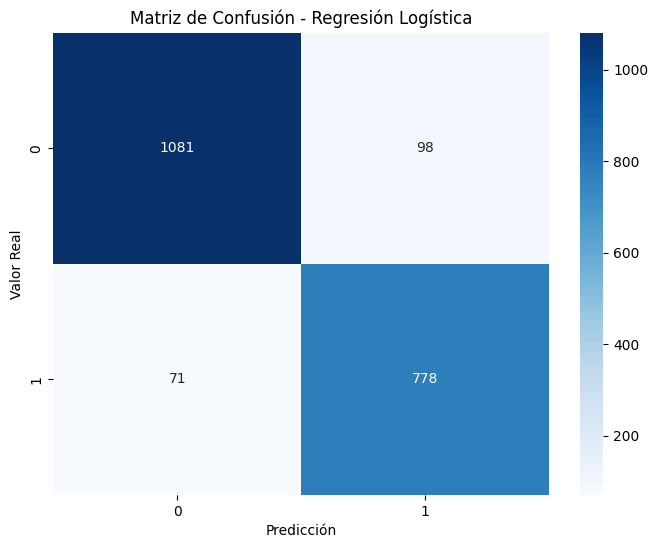

In [27]:
# Obtener predicciones y probabilidades
y_pred = mejor_logistic.predict(x_test2)
y_prob = mejor_logistic.predict_proba(x_test2)[:, 1]

# 1. Reporte de clasificación
print("Reporte de clasificación - Regresión Logística:")
print(classification_report(y_test2, y_pred))

# 2. Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test2, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()